In [79]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

### 1. load data

In [2]:
data = pd.read_csv('bike_data.csv', header=0)
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data.head()

,breakdown,cumTime,cumDist,cumRide,cumBreak,intensity,meanDist,age,summer
0,1,14910,1398094,458,1,93,3052,54,0
1,1,1281,189910,78,1,148,2434,62,0
2,1,8324,769168,332,3,92,2316,57,1
3,1,31610,2988819,949,1,94,3149,105,1
4,1,5587,518114,176,1,92,2943,41,1


### 2. feature selection

In [3]:
#독립변수 % 종속변수 정의
X = data.drop('breakdown', axis=1, inplace=False)
y = data['breakdown']

### 3. Decesion Tree fitting

In [7]:
#데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [28]:
#데이터 학습
tree = DecisionTreeClassifier(max_depth=3,random_state=0) #max_depth : 과적합방지
tree_model = tree.fit(X_train, y_train)

#성능평가
print("training set 정확도: {:.2f}".format(tree.score(X_train, y_train)))
print("test set 정확도: {:.2f}".format(tree.score(X_test, y_test)))

training set 정확도: 0.71
test set 정확도: 0.71


In [31]:
#train MSE
y_train_pred = tree.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
print("training set 오차: %.2f" % train_mse)

#test MSE
y_test_pred = tree.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print("test set 오차: %.2f" % test_mse)


training set 오차: 0.29
test set 오차: 0.29


In [33]:
print("AUC score: %.2f" % roc_auc_score(y_test, y_test_pred))

AUC score: 0.71


In [19]:
import os
os.environ['PATH'] += os.pathsep + "C:/Program Files/Graphviz/bin"

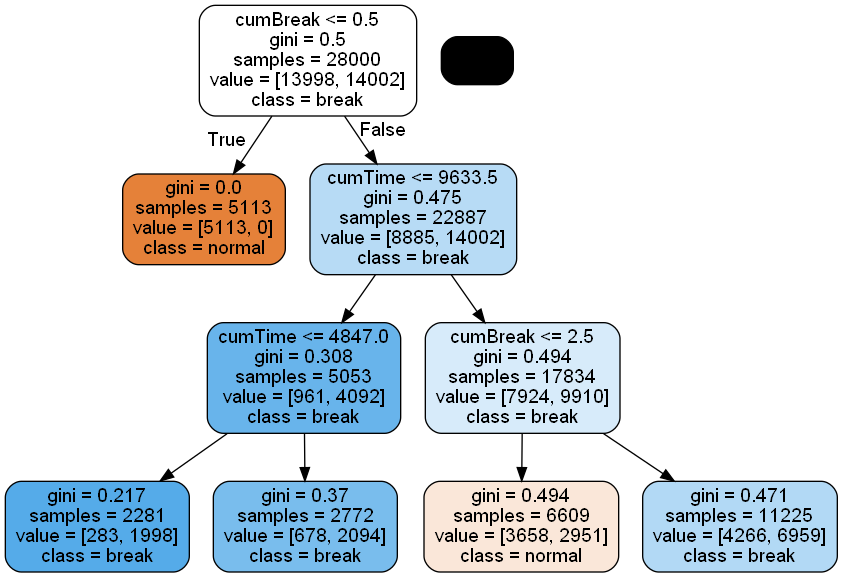

In [27]:
#tree graph
dot_data = export_graphviz(tree_model, out_file=None, class_names=['normal', 'break'],
    feature_names=X_train.columns, impurity=True, filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

gini(불순도) : 0에 가까울수록 불순도가 적은 순수노드임 <br>
samples : 데이터 수 <br>
value : 라벨의 클래스 수 <br>
class : 최종분류 <br>

### 4. Random Forest

In [39]:
#데이터 학습
rf = RandomForestClassifier(max_depth=3, n_estimators=100, random_state=0)
rf_model = rf.fit(X_train, y_train)

print("training set 정확도: {:.2f}".format(rf.score(X_train, y_train)))
print("test set 정확도: {:.2f}".format(rf.score(X_test, y_test)))

training set 정확도: 0.69
test set 정확도: 0.68


In [38]:
y_pred = rf.predict(X_test)
print("AUC score: %.2f" % roc_auc_score(y_test, y_pred))

AUC score: 0.68


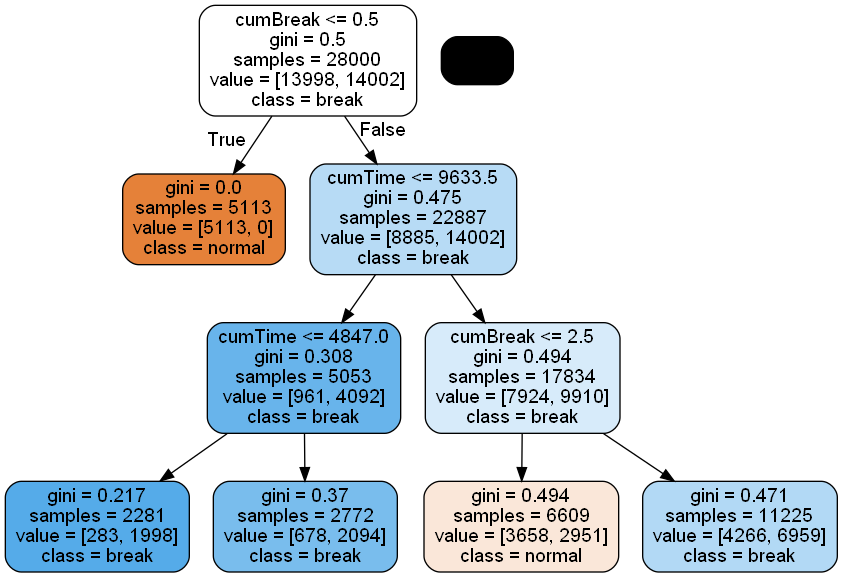

In [40]:
dot_data = export_graphviz(tree_model, out_file=None, class_names=['normal', 'break'],
    feature_names=X_train.columns, impurity=True, filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

### 5. select important feature

In [48]:
def plot_importance(model, features) :
    importances = model.feature_importances_
    indices = np.argsort(importances)
    feature_names = [features[i] for i in indices]
    feature_imp = importances[indices]

    plt.figure(figsize = (8, 6))
    plt.title('Feature importances')
    plt.barh(range(len(indices)), feature_imp, align='center')
    plt.yticks(range(len(indices)), feature_names)
    plt.xlabel('relative importance')

    print('feature : ', list(reversed(feature_names)))
    print('importance : ', list(reversed(feature_imp)))

    return list(reversed(feature_names)), list(reversed(feature_imp))

feature :  ['cumBreak', 'age', 'meanDist', 'intensity', 'cumRide', 'cumTime', 'cumDist', 'summer']
importance :  [0.6873128733812883, 0.07830662882428069, 0.06309626105632266, 0.0595822484854728, 0.0391866013473814, 0.0351371043785503, 0.019356127272523862, 0.018022155254179995]


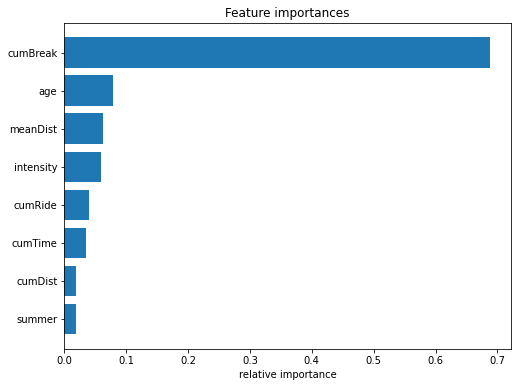

In [71]:
imp_features, imp_scores = plot_importance(rf_model, X_train.columns)

In [72]:
#random forest 모델이 중요하게 고려한 4개의 feature만 가지고 다시 학습
selected_feature = imp_features[:4]

#독립변수에서 해당 열만 추출
X_train2 = X_train.loc[:, selected_feature]
X_test2 = X_test.loc[:, selected_feature]

In [73]:
#데이터 학습
rf = RandomForestClassifier(max_depth=3, n_estimators=100, random_state=0)
rf_model2 = rf.fit(X_train2, y_train)

print("training set 정확도: {:.2f}".format(rf.score(X_train2, y_train)))
print("test set 정확도: {:.2f}".format(rf.score(X_test2, y_test)))

training set 정확도: 0.68
test set 정확도: 0.68


In [74]:
#데이터 학습
tree = DecisionTreeClassifier(max_depth=3,random_state=0) #max_depth : 과적합방지
tree_model = tree.fit(X_train2, y_train)

#성능평가
print("training set 정확도: {:.2f}".format(tree.score(X_train2, y_train)))
print("test set 정확도: {:.2f}".format(tree.score(X_test2, y_test)))

training set 정확도: 0.71
test set 정확도: 0.71


### 6. Gradient Boost

In [77]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=0, max_depth=3)
gb.fit(X_train2, y_train)

print("training set 정확도: {:.2f}".format(gb.score(X_train2, y_train)))
print("test set 정확도: {:.2f}".format(gb.score(X_test2, y_test)))

training set 정확도: 0.72
test set 정확도: 0.72


In [78]:
y_pred = gb.predict(X_test2)
print("AUC score: %.2f" % roc_auc_score(y_test, y_pred))

AUC score: 0.72


### 7. ROC curve

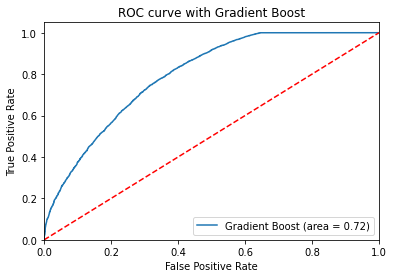

In [81]:
gb_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, gb.predict_proba(X_test2)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Gradient Boost (area = %0.2f)' % gb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve with Gradient Boost')
plt.legend(loc="lower right")
plt.savefig('ml_GB_ROC')
plt.show()